# Cell cycle model CCMMV001
**Cell cycle with constant mass model for mammalians ver. 001**

Packages

In [1]:
using DifferentialEquations
using PyDSTool, PyCall
using PyPlot
using JLD

In [2]:
include("custom_functions.jl");
include("plot_functions.jl");

### Model system of ODE's

Model function

In [3]:
f = @ode_def_bare CCMMV001 begin
    ## System of ODE (vector field)
    dMPF     = k_m0*Mass - (k_m2 + k_m2a*Wee1)*MPF + (k_m1 + k_m1a*Cdc25_P)*MPF_P - (k_m3 + k_m3a*APC_A)*MPF
    dMPF_P   = (k_m2 + k_m2a*Wee1)*MPF - (k_m1 + k_m1a*Cdc25_P)*MPF_P - (k_m3 + k_m3a*APC_A)*MPF_P
    dWee1    = V_w1*(Wee1_T - Wee1)/(J_w1 + Wee1_T - Wee1) - k_w2*(MPF + MPF_P*α)*Wee1/(J_w2 + Wee1)
    dCdc25_P = k_c1*(MPF + MPF_P*α)*(Cdc25_T - Cdc25_P)/(J_c1 + Cdc25_T - Cdc25_P) - V_c2*Cdc25_P/(J_c2 + Cdc25_P)
    dIE_A    = k_i1*(MPF + MPF_P*α)*(IE_T - IE_A)/(J_i1 + IE_T - IE_A) - V_i2*IE_A/(J_i2 + IE_A)
    dAPC_A   = k_a1*IE_A*(APC_T - APC_A)/(J_a1 + APC_T - APC_A) - V_a2*APC_A/(J_a2 + APC_A)
end k_m0=0.2 k_m1=0.4 k_m1a=20.0 k_m2=0.4 k_m2a=50.0 k_m3=0.2 k_m3a=6.35 V_w1=1.0 k_w2=5.3 J_w1=0.01 J_w2=0.01 k_c1=8.5 V_c2=>1.4 k_c2a=2.2 J_c1=0.01 J_c2=0.01 k_i1=1.7 V_i2=0.4 J_i1=0.001 J_i2=0.001 k_a1=6.8 V_a2=1.7 J_a1=0.001 J_a2=0.001 α=0.05 Mass=>0.5 Wee1_T=1.0 Cdc25_T=1.0 IE_T=1.0 APC_T=1.0 theta_M=>0.2

(::CCMMV001) (generic function with 8 methods)

**Some solutions**

**G2 stage**. Initial conditions and parameter options.

In [4]:
u0 = [0.006,      # MPF
      0.493,      # MPF_P
      0.998,      # Wee1
      0.002,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 40.0)
dtmax = 0.1
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan)
sol = solve(prob, alg; (:dtmax, dtmax))
sol.errors

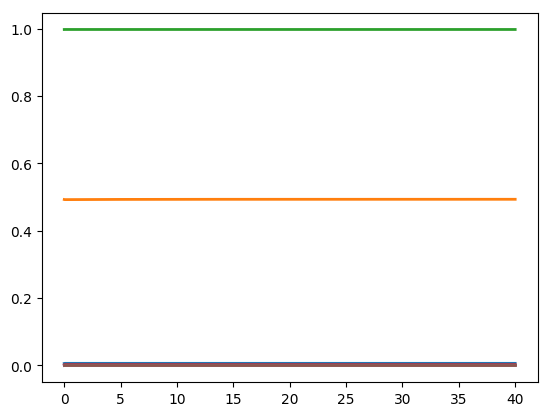

6-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0c098a7250>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c098a7450>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c098a7590>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c098a76d0>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c098a7810>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c098a7950>

In [5]:
plot(sol.t, sol.u, lw=2)

In [6]:
sol.u[end]

6-element Array{Float64,1}:
 0.00633809 
 0.493652   
 0.998056   
 0.00229212 
 0.000151684
 6.06497e-7 

**M phase**. Changing $Mass$ to 3.0. This moves the dynamics to oscillations.

In [7]:
f.Mass = 3.0
tspan=(0.0, 40.0)
prob = ODEProblem(f, u0, tspan)
dtmax = 0.001
sol = solve(prob, alg; (:dtmax, dtmax))
sol.errors

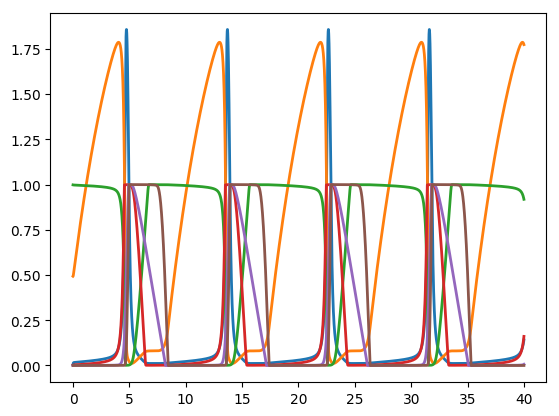

6-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0c0302afd0>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c02fb8210>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c02fb8350>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c02fb8490>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c02fb85d0>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c02fb8710>

In [8]:
plot(sol.t, sol.u, lw=2)

### Find limit cycle

In [9]:
function find_limit_cycle(f, u0, tspan; alg=Rosenbrock23(), kwargs...)
    function division(t,u,integrator)
        ## Parameters
        ## Set of condition: MPF crosses threshold from positive to negative
        u[1] - f.theta_M
    end # ModelCond
    function cycle_stop!(integrator)
        terminate!(integrator)
    end
    cb_start = ContinuousCallback(division, nothing, cycle_stop!)
    # Integrate until first division
    # NOTE: assert tspan is larger than needed
    prob = ODEProblem(f, u0, tspan)
    sol = solve(prob, alg, callback=cb_start; kwargs...)
    # One full cycle
    u0_start = sol.u[end]
    prob = ODEProblem(f, u0_start, tspan)
    sol = solve(prob, alg, callback=cb_start; kwargs...)
    # Done
    sol
end #function find_cell_cycle

find_limit_cycle (generic function with 1 method)

In [10]:
u0 = [0.006,      # MPF
      0.493,      # MPF_P
      0.998,      # Wee1
      0.002,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 10.0)
dtmax = 0.001
sol = find_limit_cycle(f, u0, tspan; (:dtmax, dtmax))
cycle = sol
sol.errors

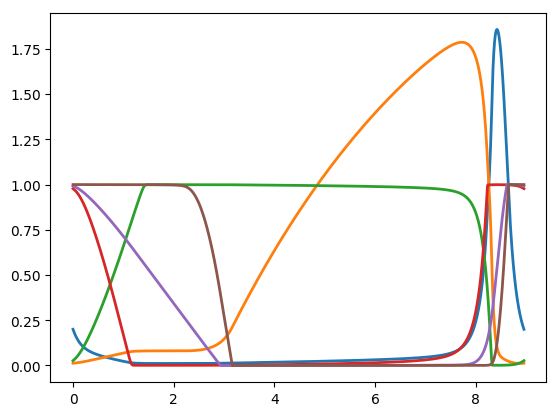

6-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0c03552750>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c03552950>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c03552a90>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c03552bd0>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c03552d10>
 PyObject <matplotlib.lines.Line2D object at 0x7f0c03552e50>

In [11]:
plot(sol.t, sol.u, lw=2)

Value of solution at the stady state for $V_{c2}$

## Bifurcation

**Following steady state with variable Mass**

In [12]:
u0 = [0.00633974,
      0.493818,
      0.998055,
      0.00229303,
      0.00015174,
      6.06721e-7]
tspan = [0, 40]
dsargs = build_ode(f,u0,tspan)
dsargs[:pdomain] = Dict("Mass"=>[0.01, 4], "V_c2"=>[0.0, 6])
ode = ds[:Generator][:Vode_ODEsystem](dsargs)
ode[:set](pars = Dict("Mass"=>0.5))
PC = ds[:ContClass](ode)

PyObject ContClass of model CCMMV001

In [ ]:
name1 = "EQ1"
PCargs = ds[:args](name=name1)
PCargs[:type] = "EP-C"
PCargs[:freepars] = ["Mass"]
PCargs[:MaxNumPoints] = 300
PCargs[:MaxStepSize] = 5e-2
PCargs[:MinStepSize] = 1e-5
PCargs[:MaxTestIters] = 20
PCargs[:LocBifPoints] = "all"
PCargs[:SaveEigen] = true
PCargs[:StopAtPoints] = ["B"]
PCargs[:verbosity] = 2
PC[:newCurve](PCargs)

In [13]:
# Commented to save computation, load "CCCMV001_data.jld"
#PC[:curves][name1][:backward]()
#PC[:curves][name1][:forward]()
#PC[:curves][name1][:info]()

B Point found 
0 : 
MPF  =  0.000117793680833
Cdc25_P  =  3.69192197147e-05
IE_A  =  2.60475775656e-06
APC_A  =  1.04087307443e-08
Mass  =  0.00999998745237
MPF_P  =  0.00988219046677
Wee1  =  0.999967786802


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000009
  |transpose(A)p| = 0.000053

LP Point found 
0 : 
MPF  =  0.048611037416
Cdc25_P  =  0.0405040834752
IE_A  =  0.00130776802641
APC_A  =  5.2532991656e-06
Mass  =  1.74608527371
MPF_P  =  1.69718305137
Wee1  =  0.976641946825

Eigenvalues = 

     (-1682.280226,0.000000)
     (-75.106316,0.000000)
     (-56.244481,0.000000)
     (-0.000009,0.000000)
     (-0.198251,0.000000)
     (-8.894382,0.000000)


a = 68.048401287047255

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 

Neutral saddle found!

Neutral saddle found!

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 


Checking...
  |q| = 1.000000
  

In [14]:
curve_stst = bifurcation_curve_ccc(PC, "EQ1");

### Follow limit cycle

In [15]:
function follow_limit_cycle(initcycle, pdomain, stepsize; kwargs...)
    cycle = deepcopy(initcycle)
    f = cycle.prob.f
    # Start
    minmax = extrema(cycle[1, :])
    T = cycle.t[end] - cycle.t[1]
    out = [[f.Mass, minmax[1], minmax[2]]]
    # Forward
    while (f.Mass < (pdomain[2] - stepsize))
        f.Mass += stepsize
        u0 = cycle.u[end]
        tspan = (0.0, 1.3*T)
        cycle = find_limit_cycle(f, u0, tspan; kwargs...)
        minmax = extrema(cycle[1, :])
        T = cycle.t[end] - cycle.t[1]
        push!(out, [f.Mass, minmax[1], minmax[2]])
    end
    # Backward
    cycle = deepcopy(initcycle)
    f = cycle.prob.f
    while ((pdomain[1] + stepsize) < f.Mass)
        f.Mass -= stepsize
        u0 = cycle.u[end]
        tspan = (0.0, 1.5*T)
        cycle = find_limit_cycle(f, u0, tspan; kwargs...)
        minmax = extrema(cycle[1, :])
        T = cycle.t[end] - cycle.t[1]
        push!(out, [f.Mass, minmax[1], minmax[2]])
    end
    temp = sort(out, by = x -> x[1])
    temp = hcat(temp...)
    dict1 = Dict([:min=>temp[2,:], :max=>temp[3,:]])
    dict2 = OrderedDict(Dict([:Mass=>temp[1,:], :MPF=>dict1]))
    BifurcationCurve(dict2, repeat(["LC"], inner=[length(out)]), Dict{String,Any}(), Int[])
end

follow_limit_cycle (generic function with 1 method)

In [16]:
# Commented to save computation, load "CCCMV001_data.jld"
#dtmax = 0.001
#curve_lcycle = follow_limit_cycle(cycle, [1.747, 4.0], 0.01; (:dtmax, dtmax))

BifurcationCurve{DataStructures.OrderedDict{Symbol,Any},Dict{String,Any}}(DataStructures.OrderedDict{Symbol,Any}(:MPF=>Dict(:max=>[1.60713, 1.61248, 1.61697, 1.62104, 1.62482, 1.6284, 1.63183, 1.63512, 1.6383, 1.64139  …  1.97266, 1.97382, 1.97498, 1.97614, 1.97729, 1.97845, 1.9796, 1.98075, 1.98189, 1.98304],:min=>[0.0064886, 0.00652575, 0.0065629, 0.00660005, 0.0066372, 0.00667435, 0.00671151, 0.00674866, 0.00678582, 0.00682297  …  0.0145347, 0.0145721, 0.0146094, 0.0146468, 0.0146842, 0.0147215, 0.0147589, 0.0147963, 0.0148336, 0.014871]),:Mass=>[1.75, 1.76, 1.77, 1.78, 1.79, 1.8, 1.81, 1.82, 1.83, 1.84  …  3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.0]), String["LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC"  …  "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC"], Dict{String,Any}(), Int64[])

Save and load

In [17]:
@load "CCMMV001_data.jld"

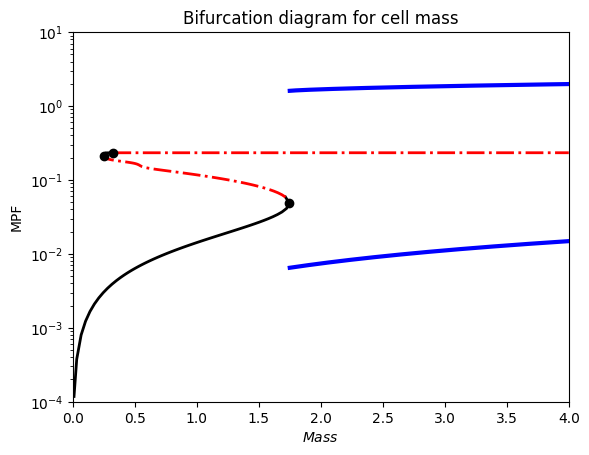

In [18]:
PlotBifurcation(curve_stst, (:Mass, :MPF))
PlotBifurcation(curve_lcycle, (:Mass, :MPF))
xlim([0, 4])
xlabel(L"Mass")
ylabel("MPF")
yscale("log")
ylim([0.0001, 10])
title("Bifurcation diagram for cell mass")
show()

In [19]:
#= Doesn't work: AUTO not supported
name2 = "HP3"
PCargs = ds[:args](name=name2)
PCargs[:type] = "LC-C"
PCargs[:initpoint] = "EQ1:H1"
PCargs[:freepars] = ["Mass"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 10
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-4
PCargs[:verbosity] = 2
PCargs[:SaveEigen] = true
PC[:newCurve](PCargs)
PC[:curves][name2][:forward]()
PC[:info]()
=#

**Two parameter bifurcation**: Mass and $V_{c2}$

Three fold points: first limit point (SNIC), second limit point (saddle-node), and Hopf point

In [ ]:
namefold1="FO1"
PCargs = ds[:args](name=namefold1)
PCargs[:type] = "LP-C"
PCargs[:initpoint] = "EQ1:LP1"
PCargs[:freepars] = ["Mass", "V_c2"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 100
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-4
PCargs[:SaveEigen] = true
PCargs[:SaveJacobian] = true
PCargs[:LocBifPoints] = ["B"]
PCargs[:StopAtPoints] = ["B"]
PCargs[:verbosity] = 2
PC[:newCurve](PCargs)

In [20]:
#PC[:curves][namefold1][:forward]()
#PC[:curves][namefold1][:backward]()
#PC[:curves][namefold1][:info]()

B Point found 
0 : 
MPF  =  0.0445035501764
Cdc25_P  =  0.00340946167557
IE_A  =  0.00334132028907
APC_A  =  1.35326155695e-05
Mass  =  2.7811684655
MPF_P  =  2.73547047017
Wee1  =  0.813528608058
V_c2  =  6.00000004595

B Point found 
0 : 
MPF  =  0.000276168091749
Cdc25_P  =  0.0415680779124
IE_A  =  3.24730229408e-06
APC_A  =  1.2976401328e-08
Mass  =  0.0100000021685
MPF_P  =  0.00972382995671
Wee1  =  0.999959834325
V_c2  =  0.00795594858521

PyCont curve FO1 (type LP-C)
Using model: CCMMV001

Model Info
---------- 

  Variables : APC_A, Cdc25_P, IE_A, MPF, MPF_P, Wee1
  Parameters: V_c2, theta_M, Mass

Continuation Parameters
----------------------- 

name  =  FO1
auxpars  =  []
freepars  =  ['Mass', 'V_c2']
MaxNumPoints  =  100
MaxCorrIters  =  5
MaxTestIters  =  10
MaxStepSize  =  1.0
MinStepSize  =  0.0001
StepSize  =  0.743008370688
VarTol  =  1e-06
FuncTol  =  1e-06
TestTol  =  0.0001
LocBifPoints  =  ['B']
verbosity  =  2
ClosedCurve  =  50
SaveJacobian  =  True
SaveEigen  

In [21]:
curve_fold1 = bifurcation_curve_ccc(PC, "FO1");

In [ ]:
namefold2 = "FO2"
PCargs = ds[:args](name=namefold2)
PCargs[:type] = "LP-C"
PCargs[:initpoint] = "EQ1:LP2"
PCargs[:freepars] = ["Mass", "V_c2"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 100
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-6
PCargs[:SaveEigen] = true
PCargs[:verbosity] = 2
PCargs[:LocBifPoints] = ["B"]
PCargs[:StopAtPoints] = ["B"]
PC[:newCurve](PCargs)

In [22]:
#PC[:curves][namefold2][:forward]()
#PC[:curves][namefold2][:backward]()
#PC[:curves][namefold2][:info]()

B Point found 
0 : 
MPF  =  0.212201785909
Cdc25_P  =  0.999999999974
IE_A  =  0.0100192191603
APC_A  =  4.17066401332e-05
Mass  =  0.251641999497
MPF_P  =  0.0391074334824
Wee1  =  0.0679299440734
V_c2  =  4.76670927212e-09

PyCont curve FO2 (type LP-C)
Using model: CCMMV001

Model Info
---------- 

  Variables : APC_A, Cdc25_P, IE_A, MPF, MPF_P, Wee1
  Parameters: V_c2, theta_M, Mass

Continuation Parameters
----------------------- 

name  =  FO2
auxpars  =  []
freepars  =  ['Mass', 'V_c2']
MaxNumPoints  =  100
MaxCorrIters  =  5
MaxTestIters  =  10
MaxStepSize  =  1.0
MinStepSize  =  1e-06
StepSize  =  0.313464297702
VarTol  =  1e-06
FuncTol  =  1e-06
TestTol  =  0.0001
LocBifPoints  =  ['B']
verbosity  =  2
ClosedCurve  =  50
SaveJacobian  =  False
SaveEigen  =  True
Corrector  =  <bound method FoldCurve._MoorePenrose of PyCont curve FO2 (type LP-C)>
UseAuto  =  False
StopAtPoints  =  ['B']
SPOut  =  None


Special Points
-------------- 

B1, P1, P2


In [23]:
curve_fold2 = bifurcation_curve_ccc(PC, "FO2");

In [24]:
#= Doesn't work: tangent vector problem
namefold3="FO3"
PCargs = ds[:args](name=namefold3)
PCargs[:type] = "LP-C"
PCargs[:initpoint] = "EQ1:H1"
PCargs[:freepars] = ["Mass", "V_c2"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 12
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-4
PCargs[:SaveEigen] = true
PCargs[:SaveJacobian] = true
PCargs[:verbosity] = 2
PCargs[:StopAtPoints] = ["B"]
PC[:newCurve](PCargs)
PC[:curves][namefold3][:forward]()
PC[:curves][namefold3][:info]()
=#

In [25]:
#@save "CCMMV001_data.jld" curve_stst curve_lcycle curve_fold1 curve_fold2

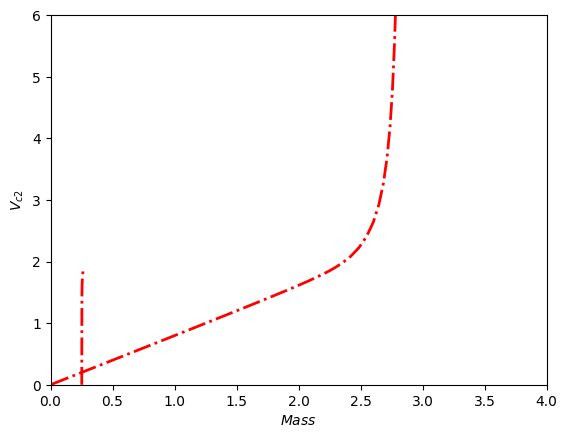

In [26]:
PlotBifurcation(curve_fold1, (:Mass, :V_c2))
PlotBifurcation(curve_fold2, (:Mass, :V_c2))
xlim([0, 4])
xlabel(L"Mass")
ylim([0, 6])
ylabel(L"V_{c2}")
title("")
show()

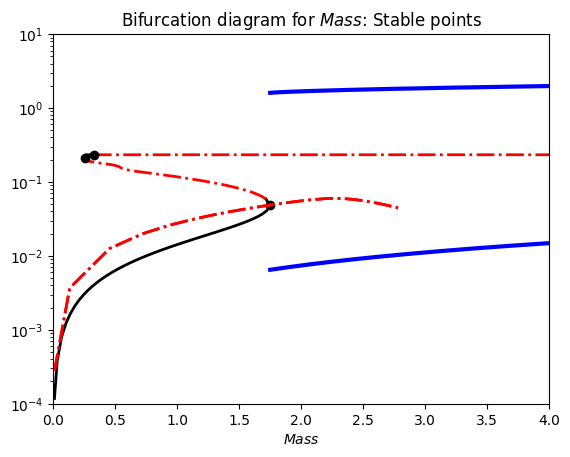

In [27]:
PlotBifurcation(curve_stst, (:Mass, :MPF))
PlotBifurcation(curve_lcycle, (:Mass, :MPF))
PlotBifurcation(curve_fold1, (:Mass, :MPF))
PlotBifurcation(curve_fold1, (:Mass, :MPF))
xlim([0, 4])
xlabel(L"Mass")
yscale("log")
ylim([0.0001, 10])
title(L"Bifurcation diagram for $Mass$: Stable points")
show()